XRF quantification
========
The fluorescence/scattered intensity $I_f$ due to irradiation with flux $I_s$

$$
\begin{equation}
I_f=I_s(Hz)\Delta t(s)\Omega(sr)\sum_{i,j}\epsilon_{i,j} c_{i,j}(sr^{-1})
\end{equation}
$$

where $I$ the detected intensity (sum of selected fluorescence and or scattering lines), $\Delta t$ the exposure time, $\Omega$ the solid angle of the detector, $\epsilon_{i,j}$ a product of filter transmission and detector absorbance and $c_{i,j}$ the rate of line $j$ with energy $E_j$ due to source line $i$ with energy $E_i$ (depending on sample composition).

As an example, the fluorescence rate of a flat-multilayer sample can be written as (only primary interactions)

$$
\begin{equation}
\begin{split}
c_{i,j}(sr^{-1})=&\frac{d\mu_{i,j}}{d\Omega}\sum_k w_{j,k}\rho_k t_k^\prime(E_i,E_j)\\
\frac{d\mu_{i,j}^{fluo}}{d\Omega} =& \frac{\mu_j(E_i)}{4\pi}\\
\frac{d\mu_{i,j}^R}{d\Omega} =& r_e^2 K_R(\phi,\theta) \frac{N_A}{M_j}f_j^2(E_i,\theta)\\
\frac{d\mu_{i,j}^C}{d\Omega} =& r_e^2 K_C(\phi,\theta) \frac{N_A}{M_j}S_j(E_i,\theta)
\end{split}
\end{equation}
$$

where $k$ loops over the layers. Note that $j$ refers to a particular interaction type (fluorescence, elastic or inelastic scattering) and to a particular atomic number $Z$. See [polarization](polarization.ipynb) for the definition of the differential scattering cross-sections (SI units $cm^2/g/sr$ and $M_j$ the molar mass of the atom ($g/mol$), $N_A$ the Avogadro constant ($1/mol$), $f$ the atomic form factor and $S$ the incoherent scattering function of the atom). 

The corrected layer thickness $t_k^\prime$ takes attenuation of primary X-rays and fluorescence/scattering into account. For a single layer in reflection geometry it can be written as

$$
\begin{equation}
\begin{split}
t^\prime(E_i,E_j) =& \frac{e^{\chi(E_i,E_j) t}-1}{\chi(E_i,E_j)\cos\alpha_{in}}\\
\chi(E_i,E_j) =& \rho\left(\frac{\mu(E_j)}{\cos\alpha_{out}}-\frac{\mu(E_i)}{\cos\alpha_{in}}\right)
\end{split}
\end{equation}
$$

where $\alpha$ the angle between the sample surface normal (pointing away from the source) and the incident(in) or fluorescence/scattering(out) direction ($\alpha_{out}>90^\circ$ in reflection geometry). Note that $\lim_{\chi\to\infty}t^\prime=\frac{t}{\cos\alpha_{in}}$.

## Geometry calibration

### Solid-angle parameterization (without standard)
See the notebook on [diodes](diodes.ipynb) on how $I_s$ is measured. We will assume the detector has a centric-cone geometry with solid angle

$$
\begin{equation}
\Omega=2\pi\left(1-\frac{x+d_0}{\sqrt{\frac{A}{\pi}+\left(x+d_0\right)^2}}\right)
\end{equation}
$$

where $A(mm^2)$ the active area of the detector, $x(mm)$ the position of the detector and $d_0(mm)$ the distance to the sample for $x=0$. To determine $A$ and $d_0$ we can measure the fluorescence of any sample as function of $x$:

$$
\begin{equation}
I_f(x,c,d_0,A)=c\Omega(x,d_0,A)
\end{equation}
$$

As an illustration we will define a detector geometry and multilayer sample. A thin-film standard is used here but any other material can be considered:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from spectrocrunch.materials import xrfstandards
from spectrocrunch.detectors import xrf as xrfdetectors
from spectrocrunch.geometries import xrf as xrfgeometries
from spectrocrunch.sources import xray as xraysources

source = xraysources.factory("synchrotron")
detector = xrfdetectors.factory("leia")
geometry = xrfgeometries.factory("sxm120",detectorposition=-10,positionunits="mm",\
                                 detector=detector,source=source)

addnoise = True # add noise to simulations done below
method = "fisx" # XRF simulation method

realsample = xrfstandards.factory("RF7-200-S2371-03",geometry=geometry,\
                                             filmthickness=10e-7) # 10 nm
print(realsample)

Multilayer (ordered top-bottom):
 Layer 0. 0.01 um (RF7-200-S2371-03)
 Layer 1. 0.2 um (silicon nitride)


Simulate a detector scan $I_f(x,c,d_0,A)$:


Theoretical geometry:
 Zero-distance: 5.0 cm
 Active area: 70.0 mm ** 2


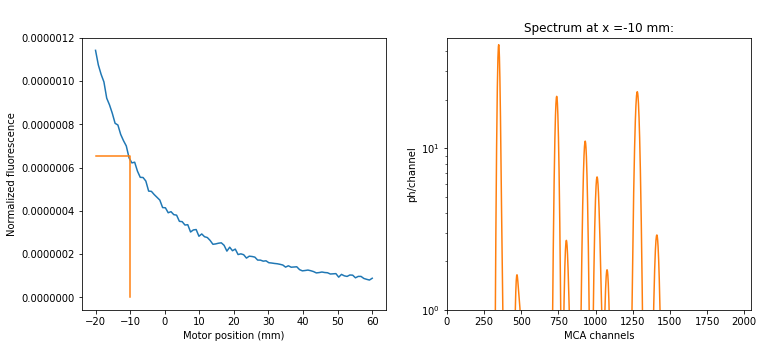

In [2]:
from spectrocrunch.common import units
from spectrocrunch.math import noisepropagation
from spectrocrunch.materials import pymca

# Geometry at which the data is collected
geometry.zerodistance = units.Quantity(5.,"cm")
detector.activearea = units.Quantity(70.,"mm^2")
print("\nTheoretical geometry:")
print(" Zero-distance: {:~}".format(geometry.zerodistance.to("cm")))
print(" Active area: {:~}".format(detector.activearea.to("mm^2")))

# Simulate measurement at current distance
energy = 7.3
flux = 1e9
time = 5
pymcahandle = pymca.PymcaHandle(sample=realsample,energy=energy,flux=flux,time=time,\
                                linear=True,escape=False,continuum=False,scatter=False)
mcaref = pymcahandle.mca(histogram=True,scattering=False,method=method)

# Simulate detector scan
n = 100
x = units.Quantity(np.linspace(-20,60,n),"mm")
I0  = np.full(n,flux*time)
solidangle = geometry.detector.solidangle_calc(activearea=detector.activearea,distance=x+geometry.zerodistance)
fluo = mcaref.sum()/geometry.solidangle*solidangle

if addnoise:
    I0 = np.random.poisson(np.round(I0).astype(int))
    fluo = np.random.poisson(np.round(fluo).astype(int))

fig,axs = plt.subplots(1,2,figsize=(12,5))

u = x.units
plt.sca(axs[0])
plt.plot(x,fluo/I0.astype(float))
xref = geometry.detectorposition.to(u).magnitude
iref = mcaref.sum()/(flux*time)
lines = plt.plot([xref,xref,x[0].magnitude],[0,iref,iref])
color = lines[0].get_color()
plt.ylabel("Normalized fluorescence")
plt.xlabel("Motor position ({:~})".format(u))

plt.sca(axs[1])
plt.plot(mcaref,color=color)
plt.gca().set_yscale('log', basey=10)
plt.xlim([0,len(mcaref)-1])
plt.ylim([1,np.max(mcaref)*1.1])
plt.ylabel("ph/channel")
plt.xlabel("MCA channels")
plt.title("\nSpectrum at x ={:~}:".format(geometry.detectorposition.to("mm")))
plt.show()

Calibrate the geometry (starting from different values as the ones used to simulate the data):


Initial geometry:
Zero-distance: 11.0 cm
Active area: 60.000000 mm ** 2


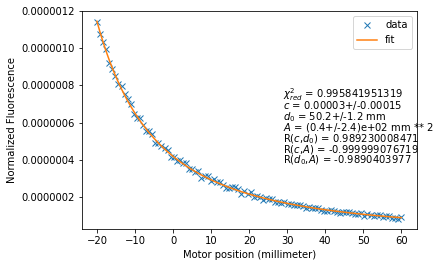

Calibrated geometry:
Zero-distance: 5.02+/-0.12 cm
Active area: 40+/-237 mm ** 2


In [3]:
# Calibration resources
fluo = noisepropagation.poisson(fluo)
I0 = noisepropagation.poisson(I0)
intensities = fluo/I0

calibrc = {"signal":noisepropagation.E(intensities),\
            "var":noisepropagation.VAR(intensities),\
            "detectorposition":x.magnitude,\
            "positionunits":x.units}

# Calibrate the geometry (starting from wrong values)
geometry.zerodistance += units.Quantity(6.,"cm")
detector.activearea += units.Quantity(-10.,"mm^2")

print("\nInitial geometry:")
print("Zero-distance: {:~}".format(geometry.zerodistance.to("cm")))
print("Active area: {:f~}".format(detector.activearea.to("mm^2")))

geometry.calibrate(calibrc=calibrc,plot=True,fit=True,fixedactivearea=False)
plt.show()

print("Calibrated geometry:")
print("Zero-distance: {:~}".format(geometry.zerodistance_rv.to("cm")))
print("Active area: {:f~}".format(detector.activearea_rv.to("mm^2")))

The correlation between $c$, $A$ and $d_0$ is too high to provide a usable result (also when fixing the active area).

### Solid-angle parameterization (with standard)

To solve the correlation issue, we determine $\Omega_{ref}$ at a particular motor position $x=x_{ref}$ by fitting the fluorescence spectrum of a standard measured with the detector at this position:

$$
\begin{equation}
\Omega_{ref}=\frac{I_{f}}{I_s(Hz)\Delta t(s)\sum_{i,j}\epsilon_{i,j} c_{i,j}(sr^{-1})}
\end{equation}
$$

where $I_s$, $\Delta t$, $\epsilon_{i,j}$ and $c_{i,j}$ are assumed to be known (flux measured by calibrated diodes, known sample and filter composition).

This provides a fixed relationship between $A$ and $d_0$ which can be substituted in the expression used for calibrating the geometry

$$
\begin{equation}
\begin{split}
I_f(x,c,d_0)=&c\Omega(x,d_0,A(d_0))\\
A(d_0)=&\pi\left(\frac{\left(x_{ref}+d_0\right)^2}{\left(1-\frac{\Omega_{ref}}{2\pi}\right)^2}-\left(x_{ref}+d_0\right)^2\right)
\end{split}
\end{equation}
$$

When using a thin-film standard, the thickness and density of the film are unknown but the areal densities of the elements in the film are known. For elements only present in the film and assuming absorption and other secondary effects are negligible, we can write

$$
\begin{equation}
\begin{split}
c_{i,j}^{film}=&\frac{d\mu_{i,j}}{d\Omega} w_{j}^{film}\rho_{film} t_{film}^{\prime}(E_i,E_j)\\
\approx&\frac{1}{\cos\alpha_{in}}\frac{d\mu_{i,j}}{d\Omega} w_{Z}^{film}\rho_{film} t_{film}\\
=&\frac{1}{\cos\alpha_{in}}\frac{d\mu_{i,j}}{d\Omega}\rho_{Z,A}^{film}
\end{split}
\end{equation}
$$

Hence for elements in the thin-film, it is enough to know their areal densities. In practice however we use mass fractions calculated from the areal densities using the density and the thickness of the substrate. The mass fractions obtained are physically meaningless but valid for the purpose of calculating $\Omega_{ref}$.

For elements in the substrate, density and thickness need to be known if self-absorption is not non-negligible:

$$
\begin{equation}
t_{subs}^{\prime}(E_i,E_j)\neq \frac{t_{subs}}{\cos\alpha_{in}}
\end{equation}
$$

Simulate and fit an XRF spectrum of a thin-film standard (simulation and fit are done with a different $d_0$ and $A$; scattering, escape and sum peaks are omitted):


Theoretical geometry:
 Zero-distance: 5.0 cm
 Active area: 70.0 mm ** 2

Fitted vs. theory (before geometry calibration):
 Mass fractions and areal densities (within one layer):
 La:   7.64 wt%     (expected:   1.31 wt%,     error: 483.70%)
 La:  52.53 ng/mm^2 (expected:   9.00 ng/mm^2, error: 483.70%)
 Mo:   0.62 wt%     (expected:   0.13 wt%,     error: 370.24%)
 Mo:   4.23 ng/mm^2 (expected:   0.90 ng/mm^2, error: 370.24%)
 Pb:   6.99 wt%     (expected:   1.12 wt%,     error: 524.48%)
 Pb:  48.09 ng/mm^2 (expected:   7.70 ng/mm^2, error: 524.48%)
 Si: 348.62 wt%     (expected:  60.06 wt%,     error: 480.45%)
 Si: 2398.51 ng/mm^2 (expected: 413.21 ng/mm^2, error: 480.45%)
 Fe:   3.41 wt%     (expected:   0.58 wt%,     error: 486.76%)
 Fe:  23.47 ng/mm^2 (expected:   4.00 ng/mm^2, error: 486.76%)
 Pd:   1.62 wt%     (expected:   0.28 wt%,     error: 487.84%)
 Pd:  11.17 ng/mm^2 (expected:   1.90 ng/mm^2, error: 487.84%)
 Ca:   9.86 wt%     (expected:   1.66 wt%,     error: 495.06%)
 

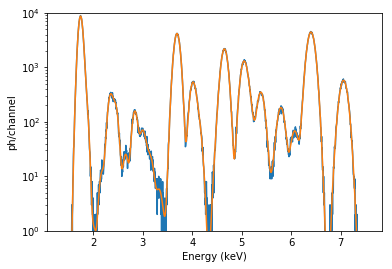

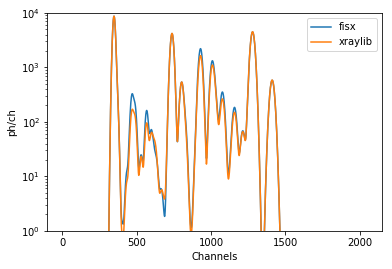

In [4]:
# Thin film standards have an unknown film thickness and density,
# only the areal densities of the different elements and the
# composition and thickness of the substrate are known.
thinfilmapprox = True

# Geometry at which the data is collected
geometry.zerodistance = units.Quantity(5.,"cm")
detector.activearea = units.Quantity(70.,"mm^2")
print("\nTheoretical geometry:")
print(" Zero-distance: {:~}".format(geometry.zerodistance_rv.to("cm")))
print(" Active area: {:~}".format(detector.activearea_rv.to("mm^2")))

# Simulate measurement (use the sample with known film thickness)
energy = 7.3
flux = 1e9
time = 1000 # the sum spectrum of a 2D map
pymcahandle = pymca.PymcaHandle(sample=realsample,energy=energy,flux=flux,time=time,\
                                linear=True,escape=False,continuum=False,scatter=False)
mca = pymcahandle.mca(histogram=True,scattering=False,method=method)
if method=="fisx":
    mca1 = mca
    mca2 = pymcahandle.mca(histogram=True,scattering=False,method="analytical")
if addnoise:
    mca = np.random.poisson(np.round(mca).astype(int))

# Calibrate with unknown film thickness
if thinfilmapprox:
    thinfilmsample = xrfstandards.factory("RF7-200-S2371-03",geometry=geometry)
    pymcahandle.sample = thinfilmsample

# Initialize fit with the wrong geometry
pymcahandle.setdata(mca)
geometry.zerodistance += units.Quantity(5.,"cm")
detector.activearea += units.Quantity(-10.,"mm^2")
pymcahandle.addtopymca(fresh=True)

# Adapt config manually if needed:
#config = pymcahandle.mcafit.getConfiguration()
#config["fit"]["stripflag"] = 0
#...
#pymcahandle.mcafit.configure(config)

# Perform fit
fitresult = pymcahandle.fit()

# Print errors
def strwerror(e,wfrac,exwfrac):
    error = (wfrac-exwfrac)/exwfrac
    return " {}: {:6.02f} wt%     (expected: {:6.02f} wt%,     error: {:.02f}%)".\
                  format(e,wfrac*100,exwfrac*100,error*100)

def straderror(e,ad,exad):
    error = (ad-exad)/exad
    return " {}: {:6.02f} ng/mm^2 (expected: {:6.02f} ng/mm^2, error: {:.02f}%)".\
                  format(e,ad*1e7,exad*1e7,error*100)
        
def printerrors(fitresult,sample):
    out = {}
    if thinfilmapprox:
        exarealdensities = sample.arealdensity()

        rho = sample[0].density
        t = sample[0].thickness
        
        for k,wfrac in fitresult["massfractions"].items():
            element = k.split("-")[0]
            ad = wfrac*rho*t
            if element in exarealdensities:
                exad = exarealdensities[element]
                exwfrac = exad/(rho*t)
                out[element] = {"ad":straderror(element,ad,exad),\
                                "wfrac":strwerror(element,wfrac,exwfrac)}
                
    else:
        exarealdensities = sample.arealdensity()
    
        arealdensities = {}
        massfractions = {}
        exmassfractions = {}
        exarealdensities = {}
        for layer,wfracs in zip(sample,fitresult["lmassfractions"]):
            rho = layer.density
            t = layer.thickness
            exwfracs = layer.elemental_massfractions()
            exad = layer.arealdensity()
            for k,wfrac in wfracs.items():
                if wfrac!=0:
                    element = k.split("-")[0]
                    arealdensities[k] = wfrac*rho*t
                    massfractions[k] = wfrac
                    exmassfractions[k] = exwfracs[element]
                    exarealdensities[k] = exad[element]

        for k,wfrac in massfractions.items():
            if k in exmassfractions:
                element = k.split("-")[0]
                exwfrac = exmassfractions[k]
                exad = exarealdensities[k]
                ad = arealdensities[k]
                out[element] = {"ad":straderror(element,ad,exad),\
                                "wfrac":strwerror(element,wfrac,exwfrac)}
    print(" Mass fractions and areal densities (within one layer):")      
    for k in out:
        print out[k]["wfrac"]
        print out[k]["ad"]

print("\nFitted vs. theory (before geometry calibration):")
printerrors(fitresult,pymcahandle.sample)

# Plot fit
def plotfit(fitresult):
    plt.plot(fitresult["energy"],fitresult["y"],label='data')
    plt.plot(fitresult["energy"],fitresult["yfit"],label='pymca fit')
    backfunc = fitresult["interpol_energy"](fitresult["yback"])
    plt.plot(fitresult["energy"],backfunc(fitresult["energy"]),label='background')
    plt.gca().set_yscale('log', basey=10)
    plt.ylim([1,np.max(fitresult["y"])*1.1])
    plt.ylabel("ph/channel")
    plt.xlabel("Energy (keV)")

plotfit(fitresult)
plt.show()

if method=="fisx":
    plt.plot(mca1,label="fisx")
    plt.plot(mca2,label="xraylib")
    plt.gca().set_yscale('log', basey=10)
    plt.ylim([1,np.max(mca)*1.1])
    plt.ylabel("ph/ch")
    plt.xlabel("Channels")
    plt.legend()
    plt.show()

Determine $\Omega_{ref}$ by comparing the fitted and theoretical fluorescence intensities:

In [5]:
caliblines = ["Ca"]
useline = lambda k: any(k.startswith(e) for e in caliblines)

# rate = Ifluo/I0 with I0 = flux * time
Rfit = {k:v for k,v in fitresult["fitrates"].items() if useline(k)}
Rinit = {k:v for k,v in fitresult["rates"].items() if useline(k)}
if thinfilmapprox:
    # for an element within the film:
    # - pymca mass fraction = 1
    # - substrate density and thicknes
    rho = pymcahandle.sample[0].density
    t = pymcahandle.sample[0].thickness
    arealdensities = pymcahandle.sample.arealdensity()
    substrate = pymcahandle.sample[0].elements
    for k in Rinit:
        el = k.split('-')[0]
        if el not in substrate:
            Rinit[k] *= arealdensities[el]/(rho*t)
            
solidangleref = geometry.solidangle * sum(Rfit.values())/sum(Rinit.values())

Calibrate the geometry ($d_0$ and $A$) with a known $[\Omega_{ref},x_{ref}]$ pair as constraint:


Calibrate geometry using ['Ca']:
 Zero-distance: 5.009+/-0.018 cm
 Active area: 71.5+/-0.6 mm ** 2

Current distance:
 Motor position = -10 mm
 Distance: 4.009+/-0.018 cm


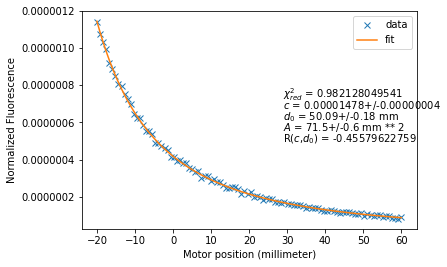

In [6]:
geometry.calibrate(calibrc=calibrc,solidanglecalib=solidangleref,\
                   plot=True,fit=True,fixedactivearea=False)

# Force to real values for testing:
#geometry.zerodistance = units.Quantity(5,"cm")
#detector.activearea = units.Quantity(70,"mm^2")

print("\nCalibrate geometry using {}:".format(caliblines))
print(" Zero-distance: {:~}".format(geometry.zerodistance_rv.to("cm")))
print(" Active area: {:~}".format(detector.activearea_rv.to("mm^2")))

print("\nCurrent distance:")
print " Motor position = {:~}".format(geometry.detectorposition)
print(" Distance: {:~}".format(geometry.distance_rv.to("cm")))

The correlation between the two unknowns $c$ and $d_0$ is low enough to provide estimates of $d_0$ and $A$ with acceptable uncertainty. Known and fitted areal densities should be the same:


Fitted vs. theory (after geometry calibration):
 Mass fractions and areal densities (within one layer):
 La:   1.28 wt%     (expected:   1.31 wt%,     error: -1.91%)
 La:   8.83 ng/mm^2 (expected:   9.00 ng/mm^2, error: -1.91%)
 Mo:   0.10 wt%     (expected:   0.13 wt%,     error: -20.98%)
 Mo:   0.71 ng/mm^2 (expected:   0.90 ng/mm^2, error: -20.98%)
 Pb:   1.17 wt%     (expected:   1.12 wt%,     error: 4.94%)
 Pb:   8.08 ng/mm^2 (expected:   7.70 ng/mm^2, error: 4.94%)
 Si:  58.59 wt%     (expected:  60.06 wt%,     error: -2.45%)
 Si: 403.07 ng/mm^2 (expected: 413.21 ng/mm^2, error: -2.45%)
 Fe:   0.57 wt%     (expected:   0.58 wt%,     error: -1.39%)
 Fe:   3.94 ng/mm^2 (expected:   4.00 ng/mm^2, error: -1.39%)
 Pd:   0.27 wt%     (expected:   0.28 wt%,     error: -1.21%)
 Pd:   1.88 ng/mm^2 (expected:   1.90 ng/mm^2, error: -1.21%)
 Ca:   1.66 wt%     (expected:   1.66 wt%,     error: 0.00%)
 Ca:  11.40 ng/mm^2 (expected:  11.40 ng/mm^2, error: 0.00%)


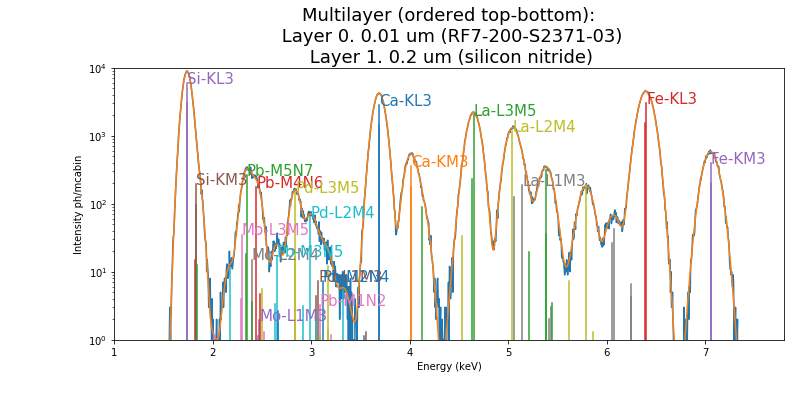

In [7]:
pymcahandle.addtopymca(fresh=False)
fitresult = pymcahandle.fit()
print("\nFitted vs. theory (after geometry calibration):")
printerrors(fitresult,pymcahandle.sample)

plt.figure(figsize=(12,5))
plotfit(fitresult)

spectrum = realsample.xrayspectrum(energy,emin=1,emax = energy+0.5,scattering=False,method=method)

matplotlib.rcParams.update({'font.size': 15})
spectrum.plot(histogram=True,decompose=True,fluxtime=pymcahandle.I0,\
              legend=False,forcelines=True)
matplotlib.rcParams.update({'font.size': 14})

plt.show()

Errors originate from least-squares fitting, the thin-film approximation (if enabled) and discrepancies between the cross-sections used to similate fluorescence and the ones used for fitting (if method not "fisx").